In [1]:
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging

import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
import xgboost as xgb
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from lineartree import LinearBoostRegressor
from matplotlib import rcParams  # Used to set default paremeters
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot
from workalendar.europe import UnitedKingdom

2024-04-01 17:21:52.136685: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-01 17:21:52.140628: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 17:21:52.394323: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 17:21:52.930456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 17:21:54.315032: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
path = os.getcwd()
path

'/home/rahuliyer/code/hramzan01/market/notebooks'

In [3]:
new_path = path.replace('notebooks', '')
new_path

'/home/rahuliyer/code/hramzan01/market/'

In [4]:
file = 'historic_demand_2009_2024_noNaN.csv'
raw_data = os.path.join(new_path, 'raw_data', file)
raw_data

'/home/rahuliyer/code/hramzan01/market/raw_data/historic_demand_2009_2024_noNaN.csv'

In [5]:
df = pd.read_csv(raw_data, index_col=0)

# Change column names to lower case and drop id (row number)
df.columns = df.columns.str.lower()

In [6]:
df.tail()

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
settlement_date,,,,,,,,,,,,,,,,,,
2024-03-07 21:30:00,44,21:30:00,30950,31827,28651,2603,6562,0,15905,0,3,1591,822,1004,-170,-104,761,0
2024-03-07 22:00:00,45,22:00:00,28691,29417,26616,2575,6562,0,15905,0,3,1299,562,761,-122,-1,544,0
2024-03-07 22:30:00,46,22:30:00,26993,27720,25041,2547,6562,0,15905,0,6,1277,541,737,-121,0,528,0
2024-03-07 23:00:00,47,23:00:00,25420,26322,23495,2580,6562,0,15905,0,15,1550,767,393,-170,0,236,0
2024-03-07 23:30:00,48,23:30:00,24359,25502,22496,2613,6562,0,15905,0,283,1573,787,385,-88,0,214,0


In [7]:
df.describe()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
count,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000
mean,24.497400,31497.308346,32975.015681,28662.954075,1248.271018,4348.665363,831.494371,8278.371301,6.997604,311.222234,912.611168,28.754904,522.307125,-116.443032,-37.262624,160.700441,0.022607
std,13.852049,7808.144316,7588.161036,7075.540769,950.745433,1943.790413,1639.094063,5683.254567,40.124803,536.074687,1084.753556,327.742836,526.470603,227.833340,256.476658,405.428489,0.148646
min,1.000000,13367.000000,16513.000000,0.000000,0.000000,1403.000000,0.000000,0.000000,-24.000000,0.000000,-2056.000000,-1030.000000,-1215.000000,-505.000000,-585.000000,-1022.000000,0.000000
25%,12.000000,25247.000000,26928.000000,22978.000000,540.000000,2092.000000,0.000000,1970.000000,0.000000,8.000000,206.000000,0.000000,0.000000,-274.000000,-168.000000,0.000000,0.000000
50%,24.000000,30884.000000,32143.000000,28099.000000,999.000000,4276.000000,0.000000,11100.000000,0.000000,11.000000,1197.000000,0.000000,749.000000,-134.000000,0.000000,0.000000,0.000000
75%,36.000000,37225.000000,38409.000000,33895.000000,1696.000000,6488.000000,802.000000,13080.000000,0.000000,396.000000,1895.000000,0.000000,994.000000,37.000000,0.000000,100.000000,0.000000
max,48.000000,59095.000000,60147.000000,53325.000000,5587.000000,6574.000000,9830.000000,15954.000000,893.000000,2019.000000,2066.000000,1016.000000,1143.000000,499.000000,504.000000,1033.000000,1.000000


In [8]:
df.shape

(265410, 18)

In [9]:
df.isna().any()

settlement_period            False
period_hour                  False
nd                           False
tsd                          False
england_wales_demand         False
embedded_wind_generation     False
embedded_wind_capacity       False
embedded_solar_generation    False
embedded_solar_capacity      False
non_bm_stor                  False
pump_storage_pumping         False
ifa_flow                     False
ifa2_flow                    False
britned_flow                 False
moyle_flow                   False
east_west_flow               False
nemo_flow                    False
is_holiday                   False
dtype: bool

In [10]:
import holidays

In [11]:
bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2025), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2025), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

True


In [12]:
bank_holiday_england

dict_items([(datetime.date(2016, 3, 25), 'Good Friday'), (datetime.date(2016, 5, 2), 'May Day'), (datetime.date(2016, 5, 30), 'Spring Bank Holiday'), (datetime.date(2016, 3, 28), 'Easter Monday'), (datetime.date(2016, 8, 29), 'Late Summer Bank Holiday'), (datetime.date(2016, 1, 1), "New Year's Day"), (datetime.date(2016, 12, 25), 'Christmas Day'), (datetime.date(2016, 12, 27), 'Christmas Day (observed)'), (datetime.date(2016, 12, 26), 'Boxing Day'), (datetime.date(2017, 4, 14), 'Good Friday'), (datetime.date(2017, 5, 1), 'May Day'), (datetime.date(2017, 5, 29), 'Spring Bank Holiday'), (datetime.date(2017, 4, 17), 'Easter Monday'), (datetime.date(2017, 8, 28), 'Late Summer Bank Holiday'), (datetime.date(2017, 1, 1), "New Year's Day"), (datetime.date(2017, 1, 2), "New Year's Day (observed)"), (datetime.date(2017, 12, 25), 'Christmas Day'), (datetime.date(2017, 12, 26), 'Boxing Day'), (datetime.date(2018, 3, 30), 'Good Friday'), (datetime.date(2018, 5, 7), 'May Day'), (datetime.date(2018,

In [13]:
df_holidays = pd.DataFrame.from_dict(bank_holiday_england)
df_holidays.columns = ['date', 'holiday']
df_holidays.head()

,date,holiday
0,2016-03-25,Good Friday
1,2016-05-02,May Day
2,2016-05-30,Spring Bank Holiday
3,2016-03-28,Easter Monday
4,2016-08-29,Late Summer Bank Holiday


In [14]:
df_holidays.sort_values(by='date', ascending=True)

,date,holiday
88,2009-01-01,New Year's Day
83,2009-04-10,Good Friday
86,2009-04-13,Easter Monday
84,2009-05-04,May Day
85,2009-05-25,Spring Bank Holiday
...,...,...
76,2024-05-06,May Day
77,2024-05-27,Spring Bank Holiday
79,2024-08-26,Late Summer Bank Holiday
81,2024-12-25,Christmas Day


In [15]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[-5:], len(holiday_dates_observed)

([numpy.datetime64('2024-05-06'),
  numpy.datetime64('2024-05-27'),
  numpy.datetime64('2024-08-26'),
  numpy.datetime64('2024-12-25'),
  numpy.datetime64('2024-12-26')],
 133)

In [16]:
holiday_names_observed[-5:], len(holiday_names_observed)

(['May Day',
  'Spring Bank Holiday',
  'Late Summer Bank Holiday',
  'Christmas Day',
  'Boxing Day'],
 133)

In [17]:
df.index

Index(['2009-01-01 00:00:00', '2009-01-01 00:30:00', '2009-01-01 01:00:00',
       '2009-01-01 01:30:00', '2009-01-01 02:00:00', '2009-01-01 02:30:00',
       '2009-01-01 03:00:00', '2009-01-01 03:30:00', '2009-01-01 04:00:00',
       '2009-01-01 04:30:00',
       ...
       '2024-03-07 19:00:00', '2024-03-07 19:30:00', '2024-03-07 20:00:00',
       '2024-03-07 20:30:00', '2024-03-07 21:00:00', '2024-03-07 21:30:00',
       '2024-03-07 22:00:00', '2024-03-07 22:30:00', '2024-03-07 23:00:00',
       '2024-03-07 23:30:00'],
      dtype='object', name='settlement_date', length=265410)

In [18]:
df.index = pd.to_datetime(df.index)
df['date'] = df.index.date

df["is_holiday"] = df["date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)
df["is_holiday"] = df["is_holiday"].astype(int)

# df["is_holiday"] = df.index.isin(holiday_dates_observed).astype(int)

In [19]:
# df["is_holiday"] = df["is_holiday"].astype(int)

# df[df["is_holiday"] == 1].sample(7)

df.head()

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday,date
settlement_date,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1,2009-01-01
2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1,2009-01-01
2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1,2009-01-01
2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1,2009-01-01
2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1,2009-01-01


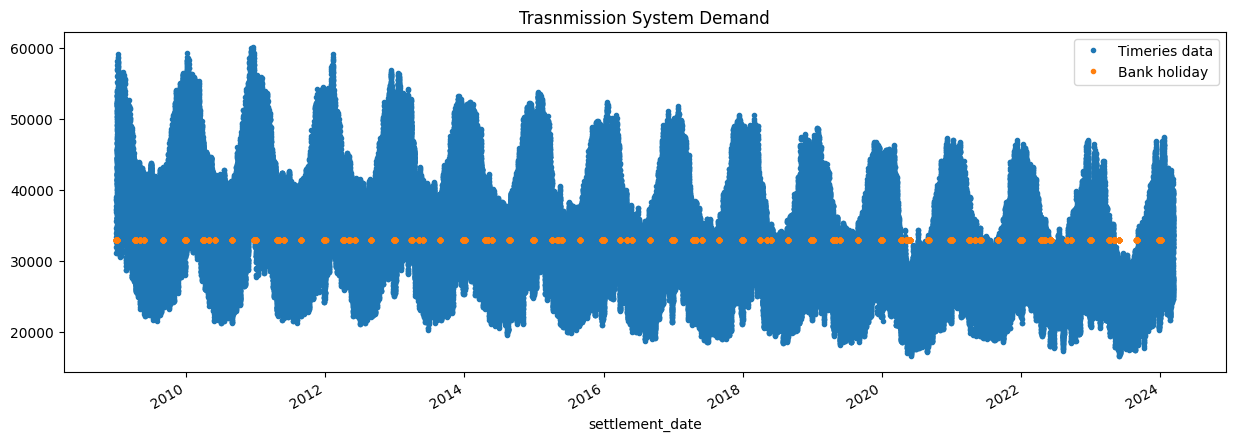

In [20]:
df_plot = df.copy()

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

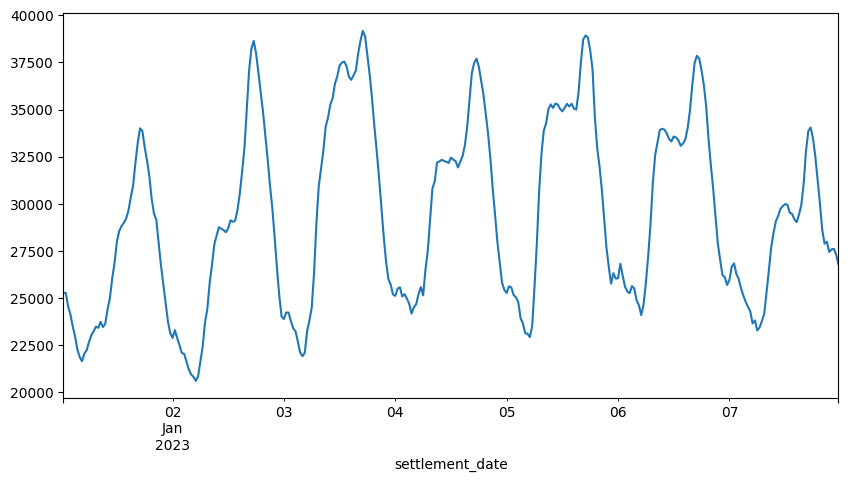

In [21]:
df_plot.loc[(df_plot.index > "01-01-2023") & (df_plot.index < "01-08-2023")][
    "tsd"
].plot(figsize=(10, 5));


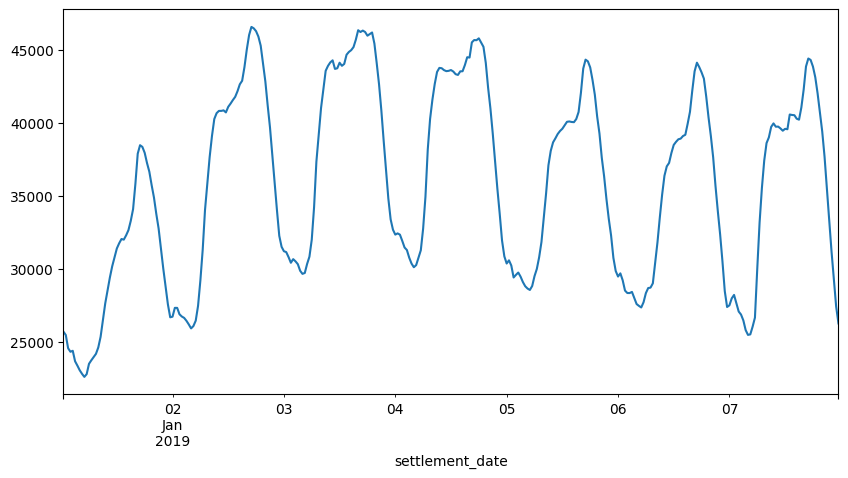

In [22]:
df_plot.loc[(df_plot.index > "01-01-2019") & (df_plot.index < "01-08-2019")][
    "tsd"
].plot(figsize=(10, 5));

In [23]:
df_plot.head()

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday,date
settlement_date,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1,2009-01-01
2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1,2009-01-01
2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1,2009-01-01
2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1,2009-01-01
2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1,2009-01-01


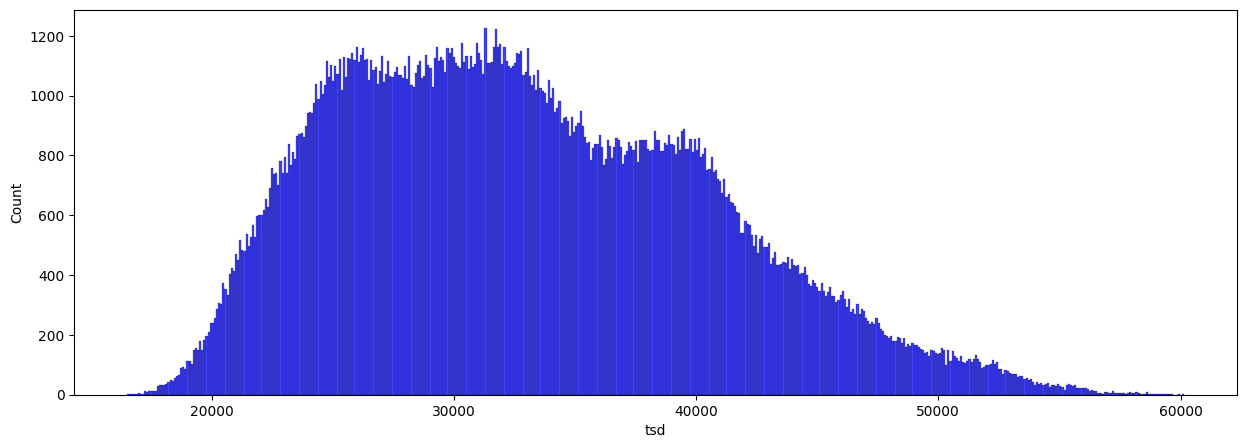

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="b");

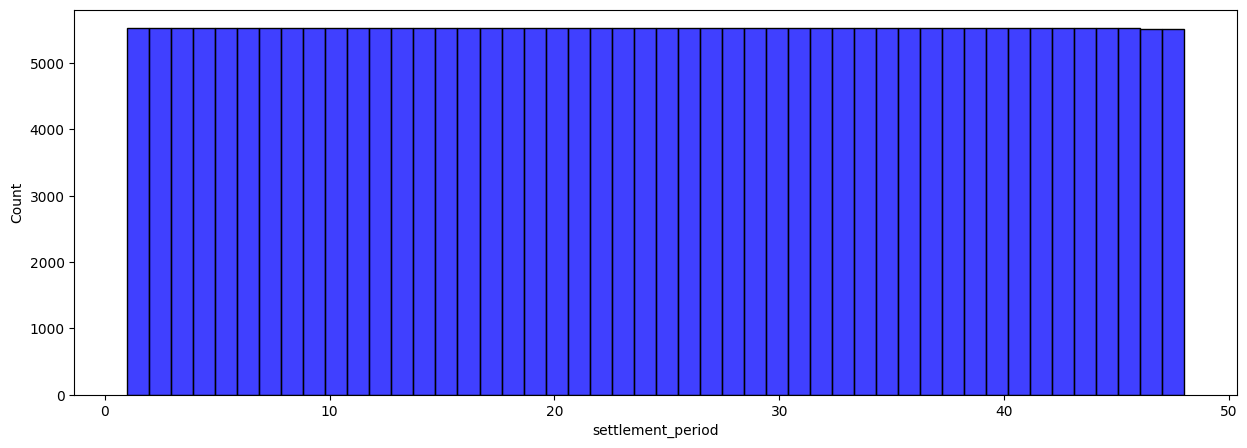

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=df, x="settlement_period", bins=48, ax=ax, color="b");

In [26]:
value_counts = df['settlement_period'].value_counts()

# Example: Get the count of 'A' in the column
count_of = value_counts[40]
count_of/365

15.150684931506849

In [27]:
def create_features(df):
    """
    Create time series features based on time series index

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df

def add_lags(df):
    """
    Add three lags to the dataset containing information from the previous 3 years.

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with lags
    """
    target_map = df["tsd"].to_dict()
    # 364 is chosen instead of 365 becuase 364 is divisible by 4 and that way we don't have to
    # map specific days
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [28]:
df = create_features(df)
df = add_lags(df)
df.head()

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3
settlement_date,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,...,1,3,1,1,1,2009,1,NaN,NaN,NaN
2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,...,1,3,1,1,1,2009,1,NaN,NaN,NaN
2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,...,1,3,1,1,1,2009,1,NaN,NaN,NaN
2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,...,1,3,1,1,1,2009,1,NaN,NaN,NaN
2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,...,1,3,1,1,1,2009,1,NaN,NaN,NaN


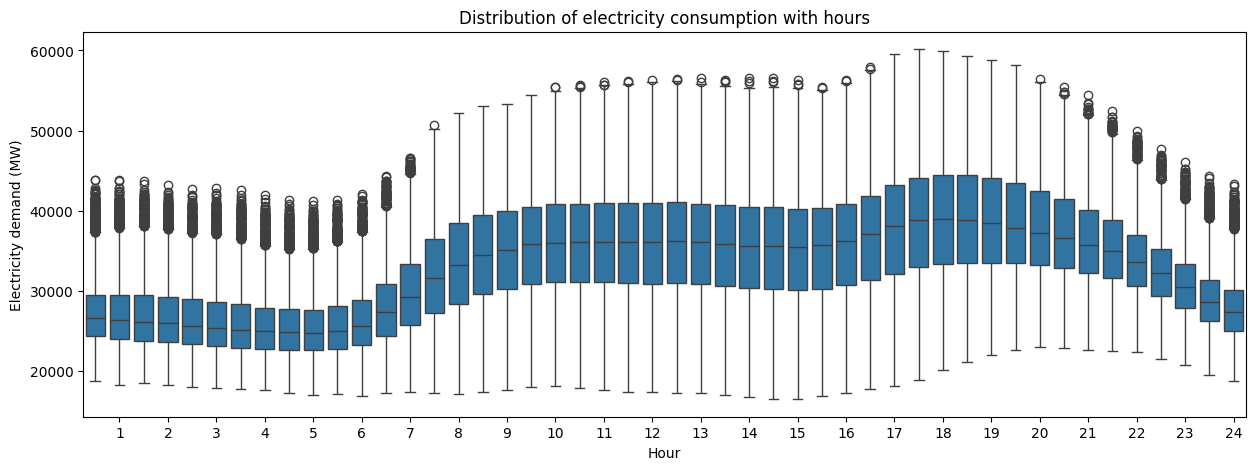

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

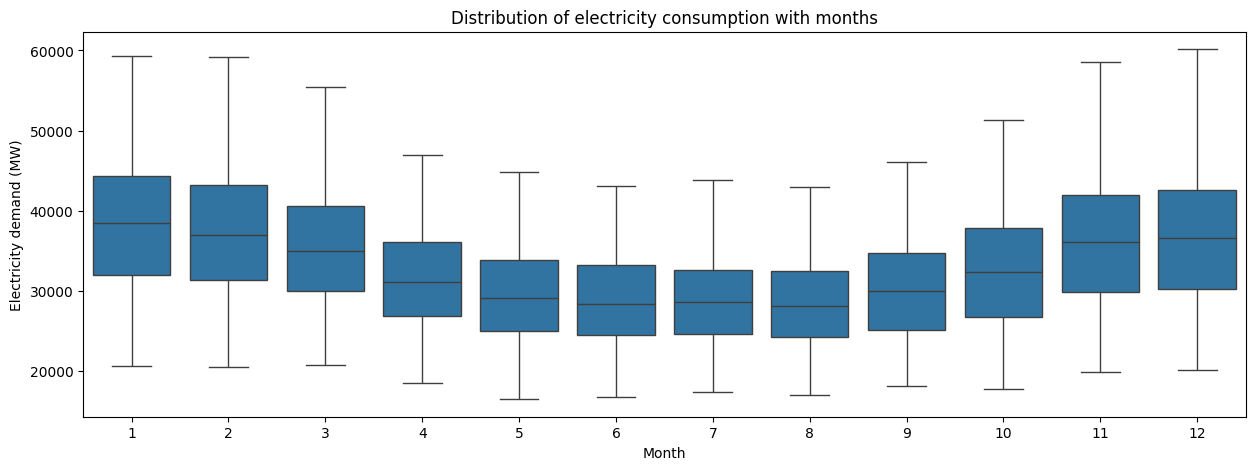

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=df)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months");

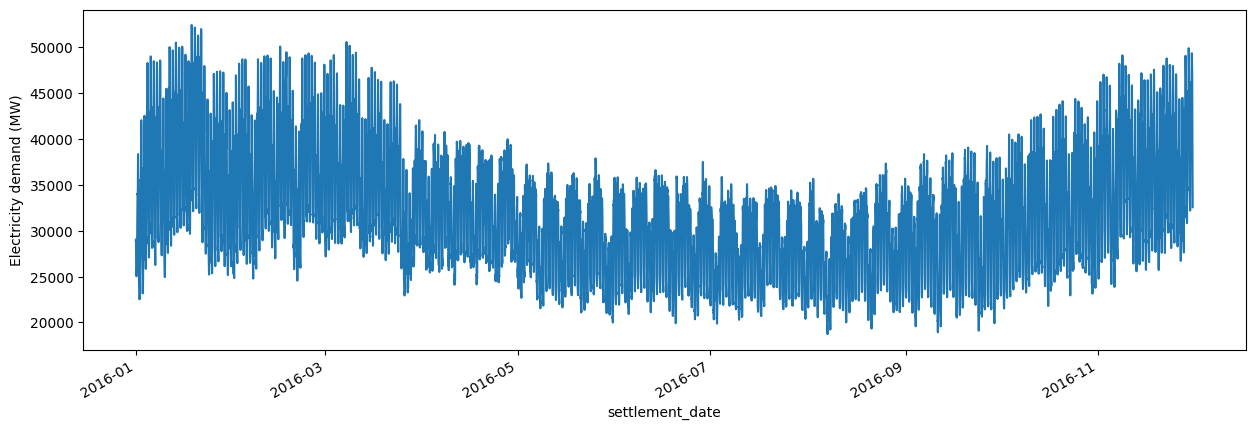

In [31]:
df.loc[(df.index > "01-01-2016") & (df.index < "12-01-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

/tmp/ipykernel_3082/1200840721.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


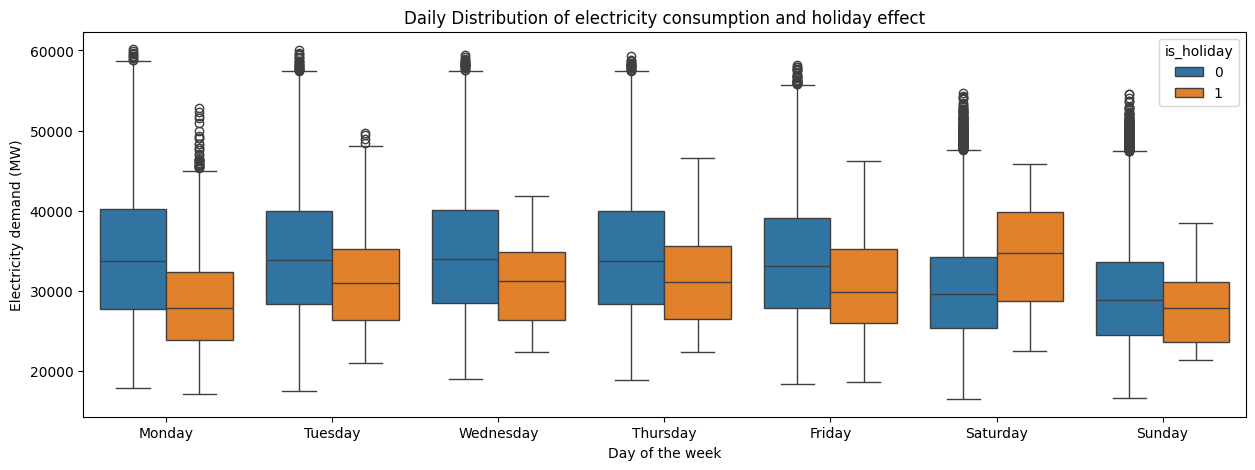

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect");

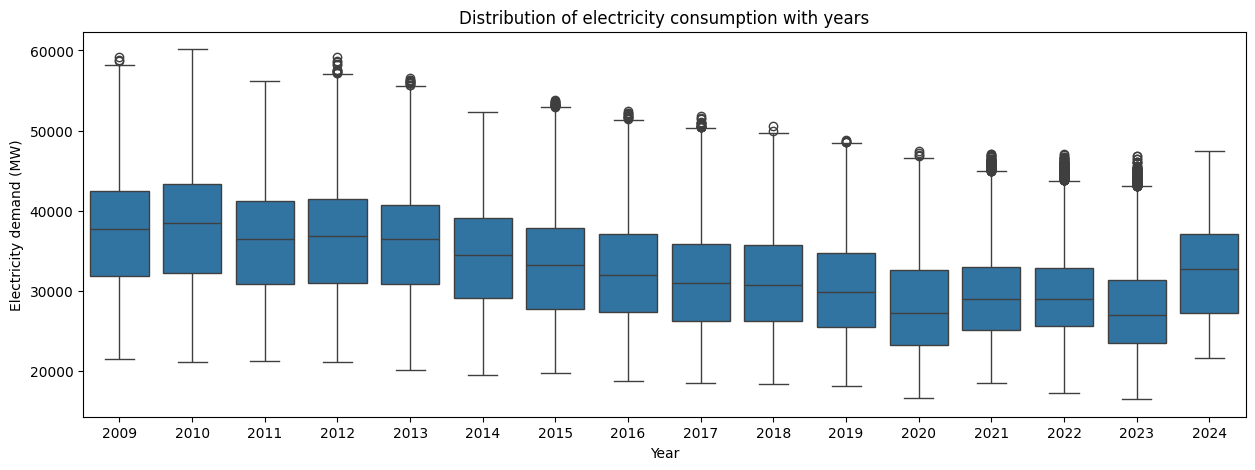

In [33]:

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=df)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years");

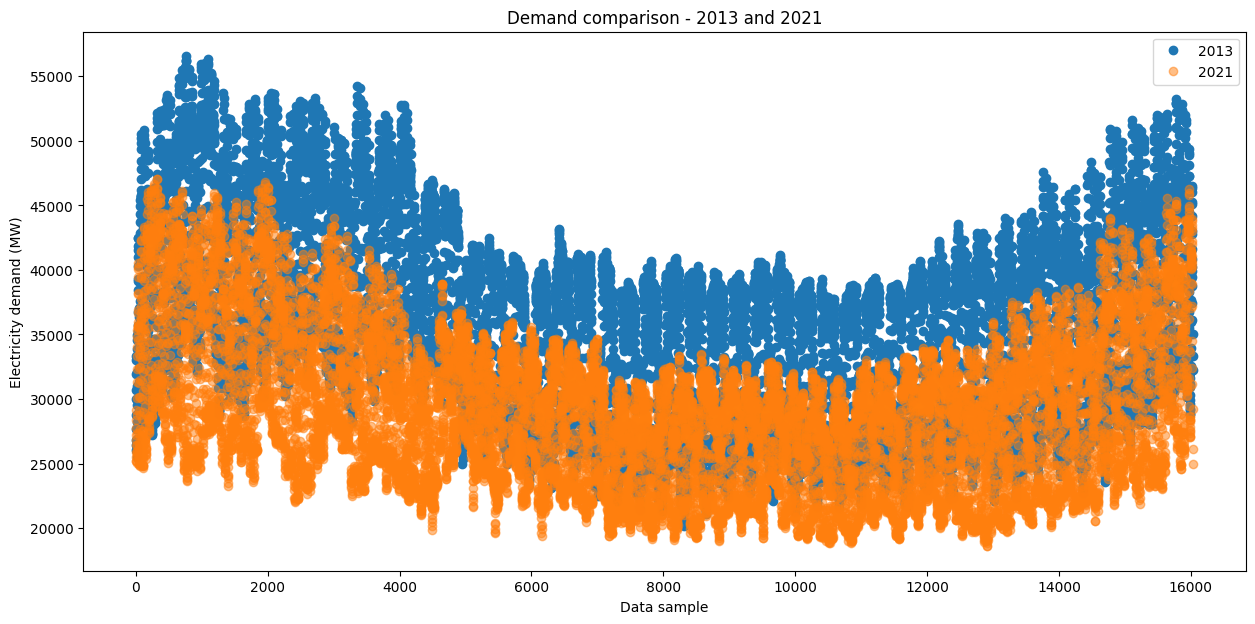

In [34]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"])),
    df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"],
    "o",
    label="2013",
)

ax.plot(
    range(len(df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"])),
    df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"],
    "o",
    alpha=0.5,
    label="2021",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021");

In [35]:
df['settlement_date'] = df.index


In [36]:
df.head()

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,day_of_week,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3,settlement_date
settlement_date,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,...,3,1,1,1,2009,1,NaN,NaN,NaN,2009-01-01 00:00:00
2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,...,3,1,1,1,2009,1,NaN,NaN,NaN,2009-01-01 00:30:00
2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,...,3,1,1,1,2009,1,NaN,NaN,NaN,2009-01-01 01:00:00
2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,...,3,1,1,1,2009,1,NaN,NaN,NaN,2009-01-01 01:30:00
2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,...,3,1,1,1,2009,1,NaN,NaN,NaN,2009-01-01 02:00:00


In [37]:
df.describe()
# null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

# null_days

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,...,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3
count,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,...,265410.000000,265410.000000,265410.000000,265410.000000,265410.000000,265410.00000,265410.000000,247312.000000,230030.000000,212556.000000
mean,24.497400,31497.308346,32975.015681,28662.954075,1248.271018,4348.665363,831.494371,8278.371301,6.997604,311.222234,...,15.710380,2.998757,181.299258,2.490584,6.464587,2016.11032,26.358720,33329.298028,33616.200817,33954.980833
std,13.852049,7808.144316,7588.161036,7075.540769,950.745433,1943.790413,1639.094063,5683.254567,40.124803,536.074687,...,8.795568,1.999274,106.189125,1.123433,3.473686,4.37954,15.170558,7578.656781,7654.662311,7688.754473
min,1.000000,13367.000000,16513.000000,0.000000,0.000000,1403.000000,0.000000,0.000000,-24.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,2009.00000,1.000000,16629.000000,16629.000000,16629.000000
25%,12.000000,25247.000000,26928.000000,22978.000000,540.000000,2092.000000,0.000000,1970.000000,0.000000,8.000000,...,8.000000,1.000000,88.000000,1.000000,3.000000,2012.00000,13.000000,27317.000000,27549.000000,27853.000000
50%,24.000000,30884.000000,32143.000000,28099.000000,999.000000,4276.000000,0.000000,11100.000000,0.000000,11.000000,...,16.000000,3.000000,181.000000,2.000000,6.000000,2016.00000,26.000000,32540.000000,32908.000000,33324.000000
75%,36.000000,37225.000000,38409.000000,33895.000000,1696.000000,6488.000000,802.000000,13080.000000,0.000000,396.000000,...,23.000000,5.000000,273.000000,3.000000,9.000000,2020.00000,40.000000,38762.000000,39135.000000,39475.000000
max,48.000000,59095.000000,60147.000000,53325.000000,5587.000000,6574.000000,9830.000000,15954.000000,893.000000,2019.000000,...,31.000000,6.000000,366.000000,4.000000,12.000000,2024.00000,53.000000,60147.000000,60147.000000,60147.000000


In [38]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

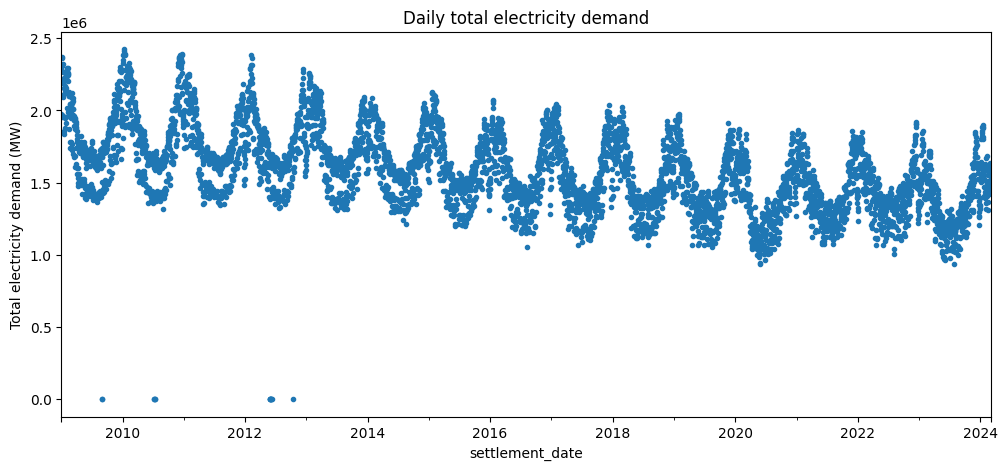

In [39]:
df_sarima = df["tsd"].resample("D").sum().to_frame()
df_sarima["month"] = df_sarima.index.month
df_sarima["year"] = df_sarima.index.year
df_sarima["settlement_date"] = df_sarima.index

df_sarima["tsd"].plot(
    style=".",
    figsize=(12, 5),
    ylabel="Total electricity demand (MW)",
    title="Daily total electricity demand",
);

In [40]:
df_sarima.head()

,tsd,month,year,settlement_date
settlement_date,,,,
2009-01-01,1849363,1,2009,2009-01-01
2009-01-02,1974406,1,2009,2009-01-02
2009-01-03,1952054,1,2009,2009-01-03
2009-01-04,1968670,1,2009,2009-01-04
2009-01-05,2271471,1,2009,2009-01-05


In [41]:
df_sarima[df_sarima['tsd']==0]

,tsd,month,year,settlement_date
settlement_date,,,,
2009-08-29,0,8,2009,2009-08-29
2009-08-30,0,8,2009,2009-08-30
2010-07-09,0,7,2010,2010-07-09
2010-07-10,0,7,2010,2010-07-10
2010-07-13,0,7,2010,2010-07-13
2010-07-14,0,7,2010,2010-07-14
2012-05-29,0,5,2012,2012-05-29
2012-05-30,0,5,2012,2012-05-30
2012-05-31,0,5,2012,2012-05-31


In [42]:
null_days = df_sarima.loc[df_sarima["tsd"] == 0.0, "settlement_date"].tolist()

pd.DataFrame(null_days)

,0
0,2009-08-29
1,2009-08-30
2,2010-07-09
3,2010-07-10
4,2010-07-13
5,2010-07-14
6,2012-05-29
7,2012-05-30
8,2012-05-31
9,2012-06-01


In [43]:
null_info = zip(
    df_sarima.loc[null_days].index.month, df_sarima.loc[null_days].index.year
)

In [44]:
null_info

In [45]:
mean_values = [
    df_sarima.loc[
        (df_sarima["month"] == info[0]) & (df_sarima["year"] == info[1]), "tsd"
    ].mean()
    for info in null_info
]

df_sarima.loc[null_days, "tsd"] = mean_values

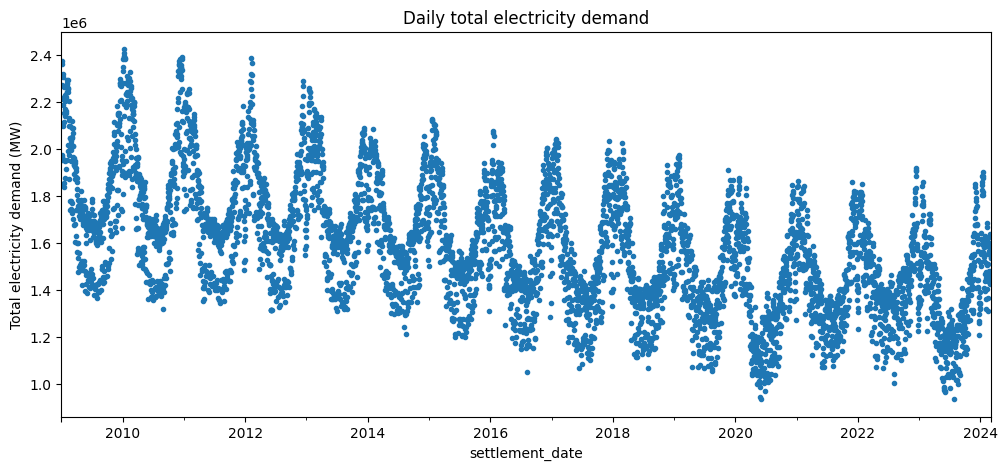

In [46]:
df_sarima["tsd"].plot(
    style=".",
    figsize=(12, 5),
    ylabel="Total electricity demand (MW)",
    title="Daily total electricity demand",
);

In [47]:
df_sarima["lag_day"] = df_sarima["tsd"].shift(1)
df_sarima["lag_year"] = df_sarima["tsd"].shift(364)


df_sarima["difference_day"] = df_sarima["tsd"] - df_sarima["lag_day"]
df_sarima["difference_year"] = df_sarima["tsd"] - df_sarima["lag_year"]

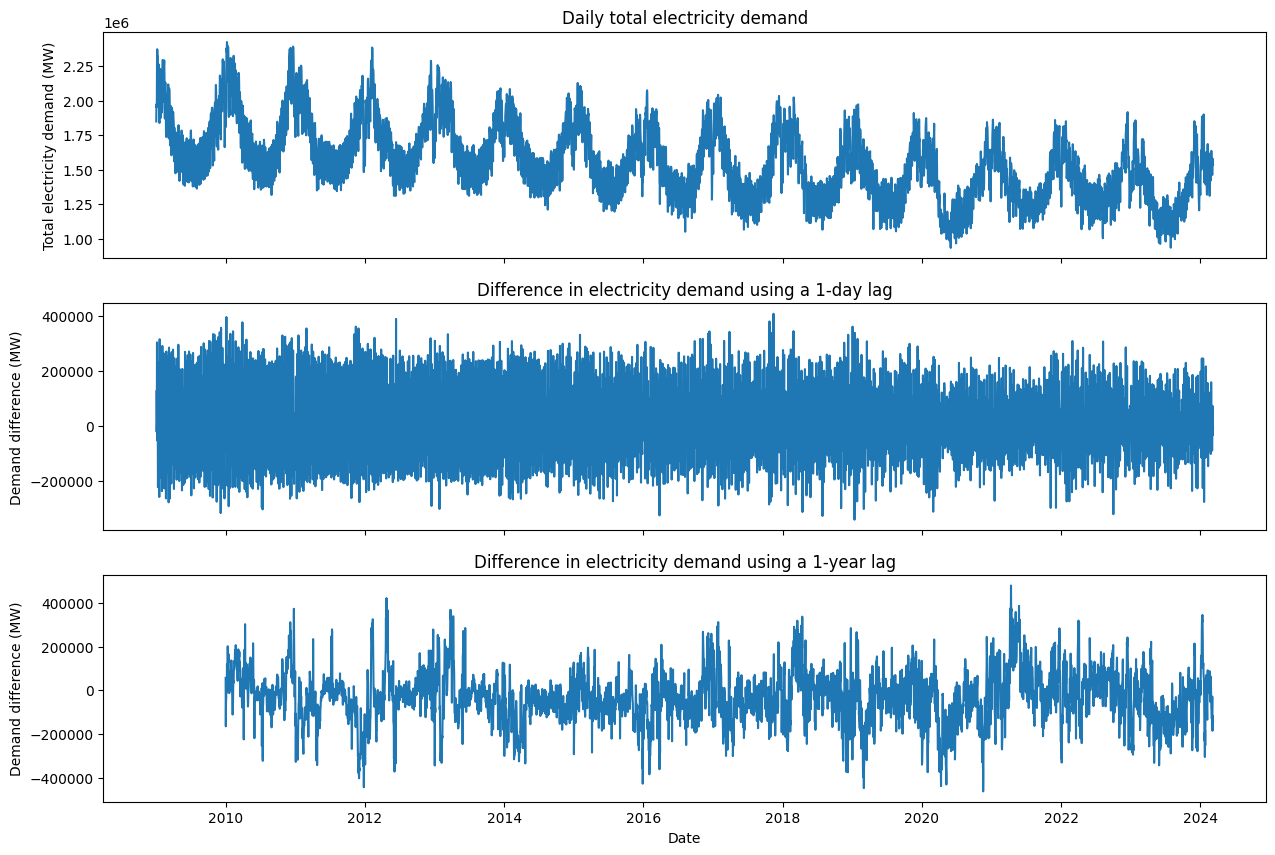

In [48]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes.ravel()
axes[0].plot(df_sarima.index, df_sarima["tsd"])
axes[0].set_ylabel("Total electricity demand (MW)")
axes[0].set_title("Daily total electricity demand")
axes[1].plot(df_sarima.index, df_sarima["difference_day"])
axes[1].set_ylabel("Demand difference (MW)")
axes[1].set_title("Difference in electricity demand using a 1-day lag")
axes[2].plot(df_sarima.index, df_sarima["difference_year"])
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Demand difference (MW)")
axes[2].set_title("Difference in electricity demand using a 1-year lag");

In [50]:
def dftest(timeseries, window_size):
    """
    Perform ADFuller test, report the results and plot rolling statistics

    Args:
        - timeseries: time series data
        - window_size: window size for rolling statistics
    """
    dftest = sm.stattools.adfuller(
        timeseries,
    )
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic", "p-value", "Lags Used", "Observations Used"],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    # Plot rolling statistics:
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.grid(True)
    plt.show(block=False)


def autocorr_plots(data, lags=None):
    """
    Plot raw data, autocorreltion plot and partial autocorrelation plot

    Args:
        - data: time series data
        - lags: number of lags for the autocorrelation plots
            Default value is None
    """
    plt.figure(figsize=(20, 10))
    layout = (3, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags, ax=acf, zero=True)
    sm.graphics.plot_pacf(data, lags=lags, ax=pacf, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()


def autocorr_plots_dual_lags(data, lags_1=None, lags_2=None):
    """
    Plot raw data, autocorreltion plot and partial autocorrelation plot
    using two lags

    Args:
        - data: time series data
        - lags_1: number of lags for first set of autocorrelation plots
            Default value is None
        - lags_2: number of lags for first set of autocorrelation plots
            Default value is None
    """
    plt.figure(figsize=(20, 14))
    layout = (5, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf_1 = plt.subplot2grid(layout, (1, 0))
    pacf_1 = plt.subplot2grid(layout, (2, 0))
    acf_2 = plt.subplot2grid(layout, (3, 0))
    pacf_2 = plt.subplot2grid(layout, (4, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags_1, ax=acf_1, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_1, ax=pacf_1, zero=True, method="ywm")
    sm.graphics.plot_acf(data, lags=lags_2, ax=acf_2, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_2, ax=pacf_2, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()

In [52]:
df_sarima.head(2)

,tsd,month,year,settlement_date,lag_day,lag_year,difference_day,difference_year
settlement_date,,,,,,,,
2009-01-01,1849363.0,1,2009,2009-01-01,NaN,NaN,NaN,NaN
2009-01-02,1974406.0,1,2009,2009-01-02,1849363.0,NaN,125043.0,NaN


Test Statistic            -3.831722
p-value                    0.002599
Lags Used                 33.000000
Observations Used       5511.000000
Critical Value (1%)       -3.431537
Critical Value (5%)       -2.862065
Critical Value (10%)      -2.567049
dtype: float64


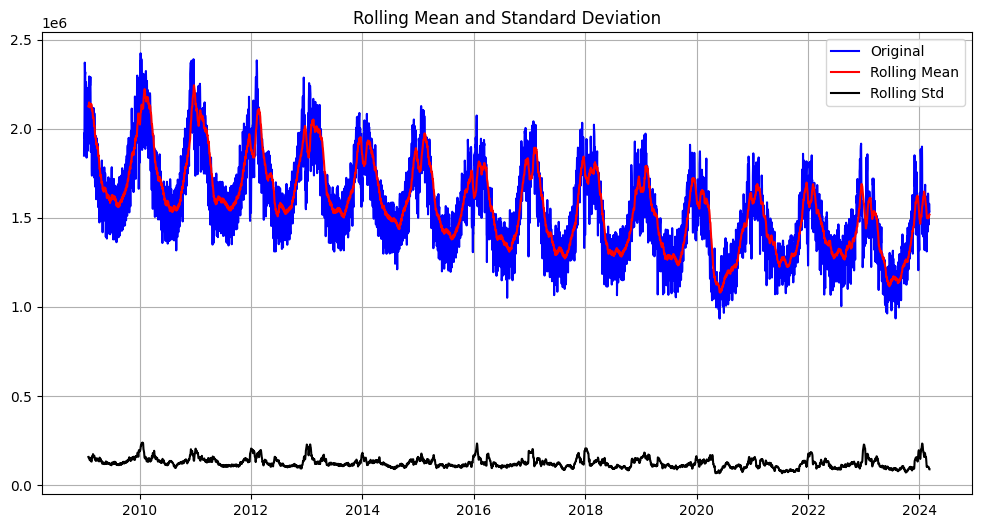

In [51]:
dftest(df_sarima["tsd"], 30)

Test Statistic         -1.780233e+01
p-value                 3.214151e-30
Lags Used               3.300000e+01
Observations Used       5.510000e+03
Critical Value (1%)    -3.431537e+00
Critical Value (5%)    -2.862065e+00
Critical Value (10%)   -2.567049e+00
dtype: float64


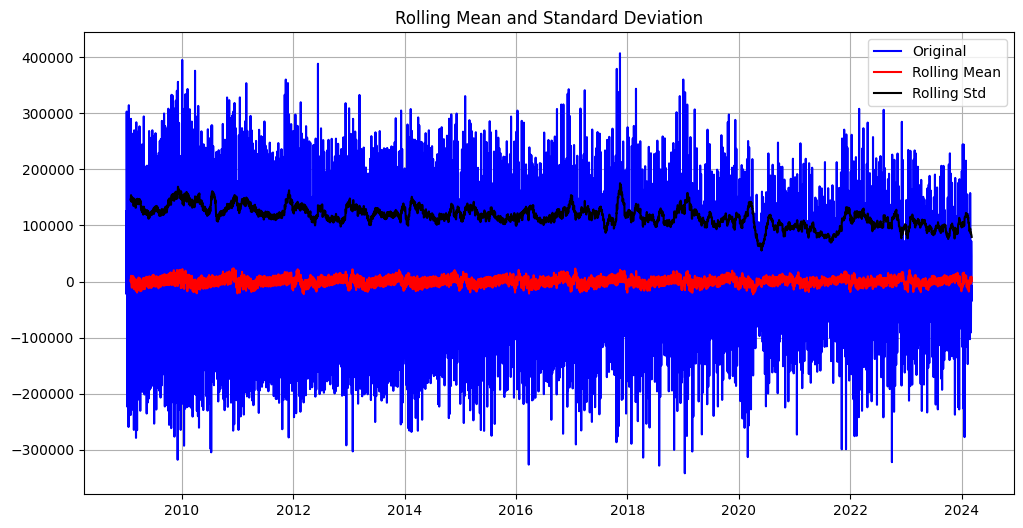

In [53]:
dftest(df_sarima["difference_day"].dropna(), 30)

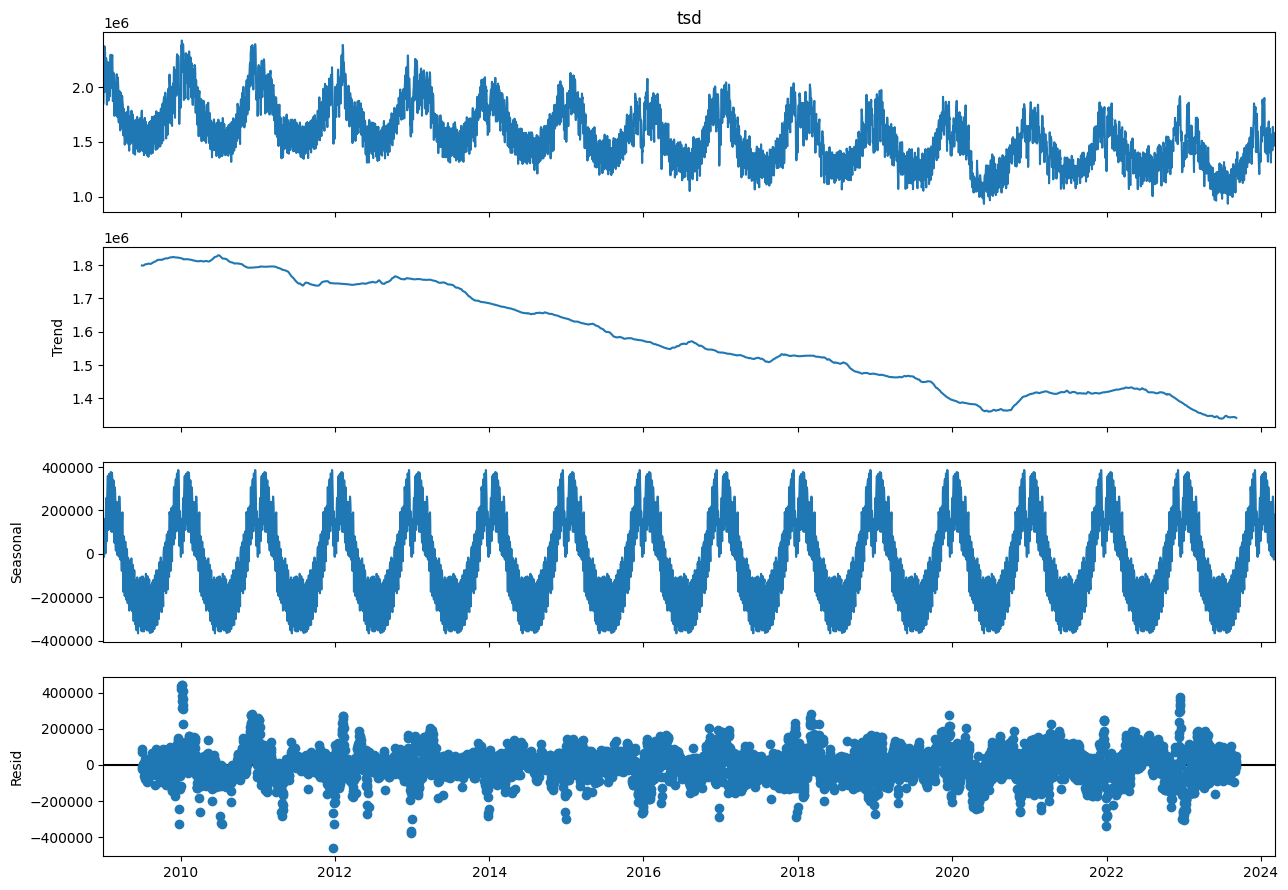

In [54]:
decompose = sm.seasonal_decompose(df_sarima["tsd"].dropna(), period=364)

fig = decompose.plot()
fig.set_size_inches((13, 9))
fig.tight_layout()

Test Statistic            -5.336604
p-value                    0.000005
Lags Used                 33.000000
Observations Used       5511.000000
Critical Value (1%)       -3.431537
Critical Value (5%)       -2.862065
Critical Value (10%)      -2.567049
dtype: float64


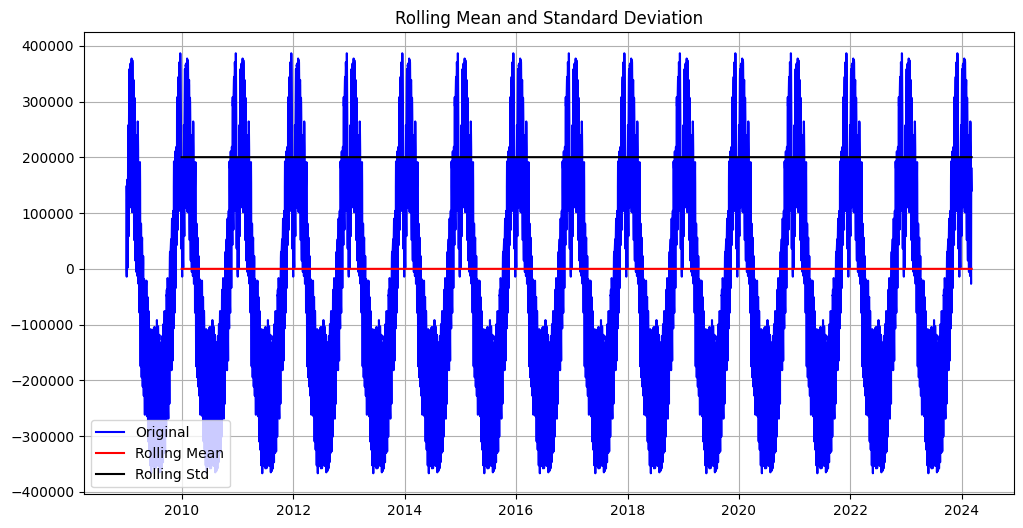

In [55]:
dftest(decompose.seasonal, 364)

Test Statistic         -8.050626e+00
p-value                 1.746016e-12
Lags Used               2.600000e+01
Observations Used       5.154000e+03
Critical Value (1%)    -3.431619e+00
Critical Value (5%)    -2.862101e+00
Critical Value (10%)   -2.567069e+00
dtype: float64


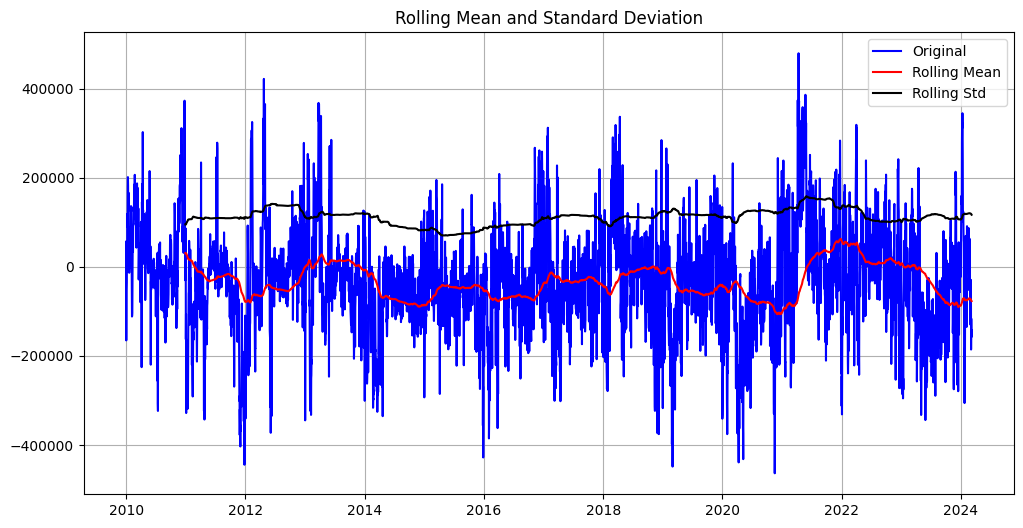

In [56]:
dftest(df_sarima["difference_year"].dropna(), 364)

In [ ]:
autocorr_plots_dual_lags(df_sarima["tsd"], lags_1=480, lags_2=31)